In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import json
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision.transforms import (CenterCrop, Compose, Resize, Normalize, ToTensor)
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torch.nn import functional as F

In [58]:
torch.cuda.is_available()

False

In [59]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [60]:
def read_img(path, transform=None):

  img = Image.open(path)

  if transform:
    tensor_ = transform(img)

  tensor = tensor_.unsqueeze(0)

  return tensor

In [61]:
def to_array(tensor):

  tensor_ = tensor.squeeze()
  unnormalize_transform = Compose([Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                   Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])])
  arr_ = unnormalize_transform(tensor_)
  arr = arr_.permute(1, 2, 0).detach().numpy()

  return arr

In [62]:
def loss_function(input, net=None, target=None):
    out = net(input)  # Output của mạng là logits (chưa chuẩn hóa)
    print(out.shape)

    # ResNet18 trả về logits, tức là các giá trị chưa được chuẩn hóa thành xác suất.
    # Tuy nhiên, hàm F.nll_loss yêu cầu đầu vào phải là log-probabilities (tức log của softmax).
    log_probs = F.log_softmax(out, dim=1)
    loss = torch.nn.functional.nll_loss(log_probs, target=torch.LongTensor([target]))
    print(f"Loss: {loss.item()}")

    return loss


In [63]:
def compute_gradient(loss_function, inp, **kwargs):

  inp.requires_grad = True
  loss = loss_function(inp, **kwargs)
  loss.backward()
  inp.requires_grad = False

  return inp.grad.data

In [64]:
# def scale_gradient(grad):

#   grad_arr = torch.abs(grad).mean(dim=1).detach().permute(1, 2, 0)
#   grad_arr_scaled = grad_arr / grad_arr.quantile(0.98)
#   grad_arr_scaled = torch.clamp(grad_arr_scaled, 0, 1)

#   return grad_arr_scaled

In [65]:
def attack(tensor, net, eps=1e-3, n_iter=50):

  new_tensor = tensor.detach().clone()
  origin_pred = net(tensor).argmax()

  print(f"Original prediction: {origin_pred.item()}")

  for i in range(n_iter):
    net.zero_grad()
    grad = compute_gradient(loss_function, new_tensor, net=net, target=origin_pred.item())
    new_tensor = torch.clamp(new_tensor + eps * grad.sign(), -2, 2)
    new_pred = net(new_tensor).argmax()

    if origin_pred != new_pred:
        print(f"We fooled the network after {i} iterations!")
        print(f"New prediction: {new_pred.item()}")
        break

  return new_tensor, origin_pred.item(), new_pred.item()

In [66]:
transform = Compose([Resize(256), CenterCrop(224), ToTensor(),
                     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [67]:
net = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [68]:
input_dir = "/content/drive/MyDrive/cs410/Assignment3/data/in_data"
output_dir = "/content/drive/MyDrive/cs410/Assignment3/data/out_data"
label_json = "/content/drive/MyDrive/cs410/Assignment3/data/imagenet-simple-labels.json"

In [69]:
with open(label_json, 'r') as f:
    class_names = json.load(f)

In [70]:
print(class_names)

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'agama', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'Nile crocodile', 'American alligator', 'triceratops', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'African rock p

In [71]:
def get_label_from_index(index):
    if 0 <= index < len(class_names):
        return class_names[index]
    else:
        return f"Unknown ({index})"

In [72]:
print(get_label_from_index(942))

butternut squash


-----------------------/content/drive/MyDrive/cs410/Assignment3/data/in_data/img_1.jpg-----------------------
Original prediction: 37
torch.Size([1, 1000])
Loss: 0.05347732454538345
torch.Size([1, 1000])
Loss: 0.076975978910923
torch.Size([1, 1000])
Loss: 0.11742322146892548
torch.Size([1, 1000])
Loss: 0.175833597779274
torch.Size([1, 1000])
Loss: 0.25606465339660645
torch.Size([1, 1000])
Loss: 0.36310434341430664
torch.Size([1, 1000])
Loss: 0.49845466017723083
torch.Size([1, 1000])
Loss: 0.6654938459396362
torch.Size([1, 1000])
Loss: 0.8636847138404846
We fooled the network after 8 iterations!
New prediction: 36
-----------------------/content/drive/MyDrive/cs410/Assignment3/data/in_data/img_2.jpg-----------------------
Original prediction: 273
torch.Size([1, 1000])
Loss: 0.01940797083079815
torch.Size([1, 1000])
Loss: 0.050382621586322784
torch.Size([1, 1000])
Loss: 0.1383778303861618
torch.Size([1, 1000])
Loss: 0.35806089639663696
We fooled the network after 3 iterations!
New predic

We fooled the network after 5 iterations!
New prediction: 939
-----------------------/content/drive/MyDrive/cs410/Assignment3/data/in_data/img_5.jpg-----------------------
Original prediction: 707
torch.Size([1, 1000])
Loss: 0.0051108901388943195
torch.Size([1, 1000])
Loss: 0.03667495772242546
torch.Size([1, 1000])
Loss: 0.17138706147670746
torch.Size([1, 1000])
Loss: 0.6566140055656433
We fooled the network after 3 iterations!
New prediction: 804


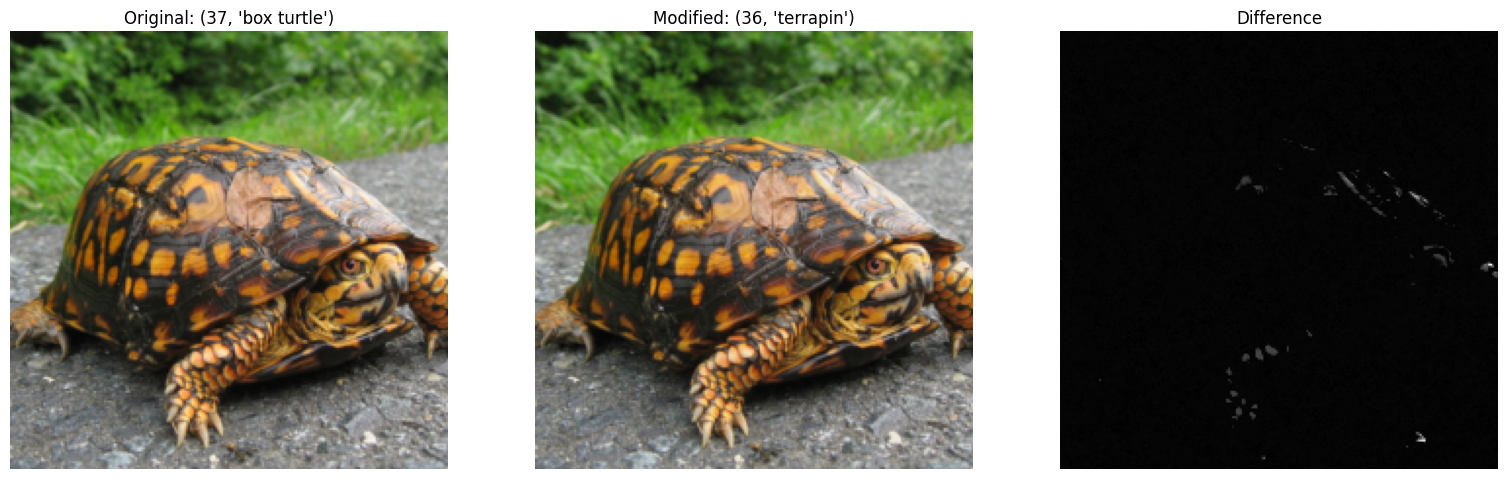

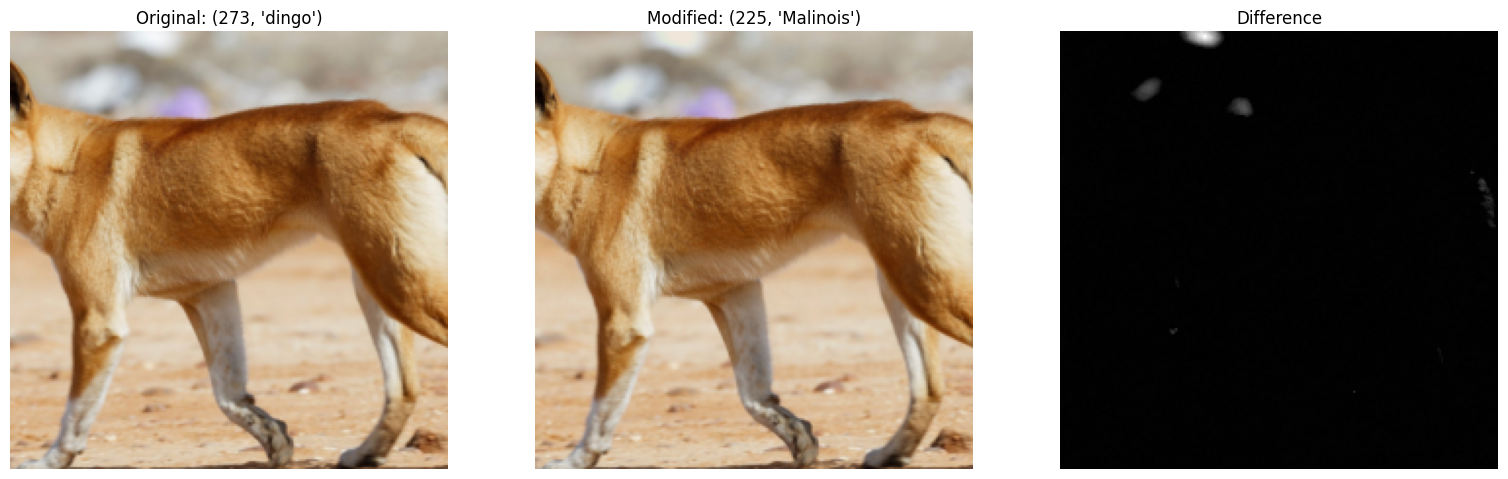

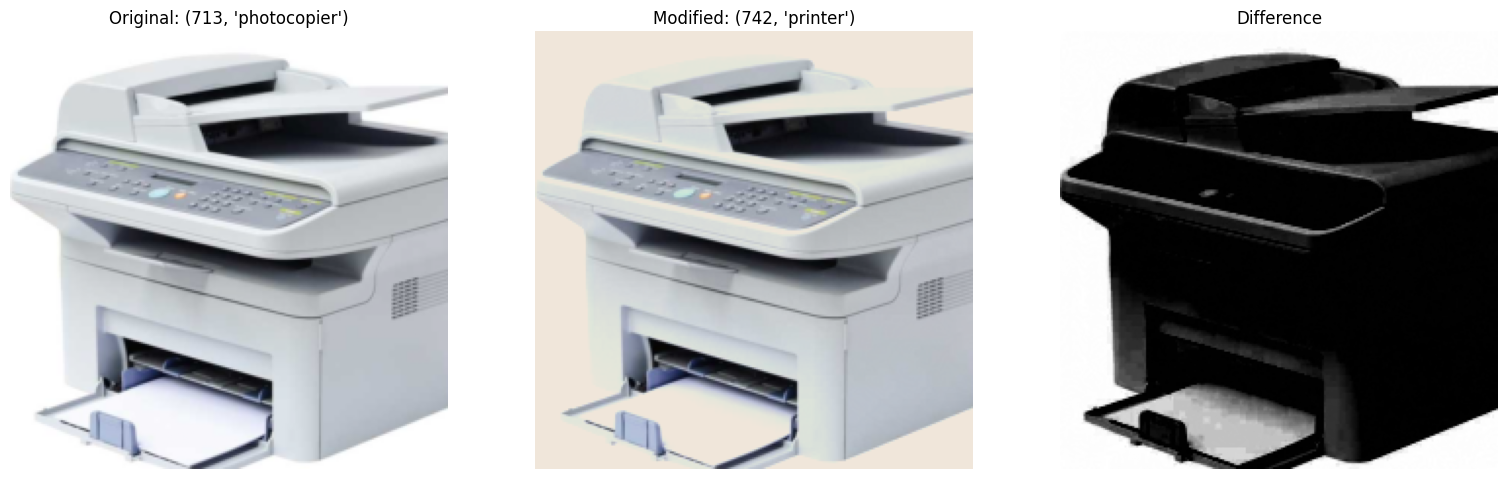

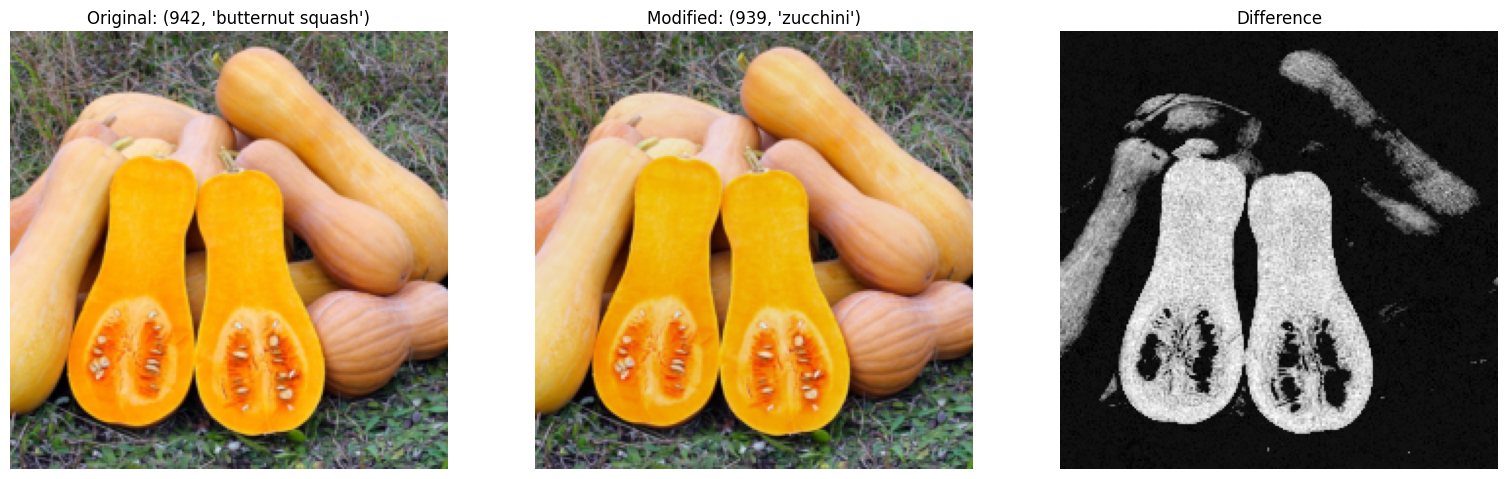

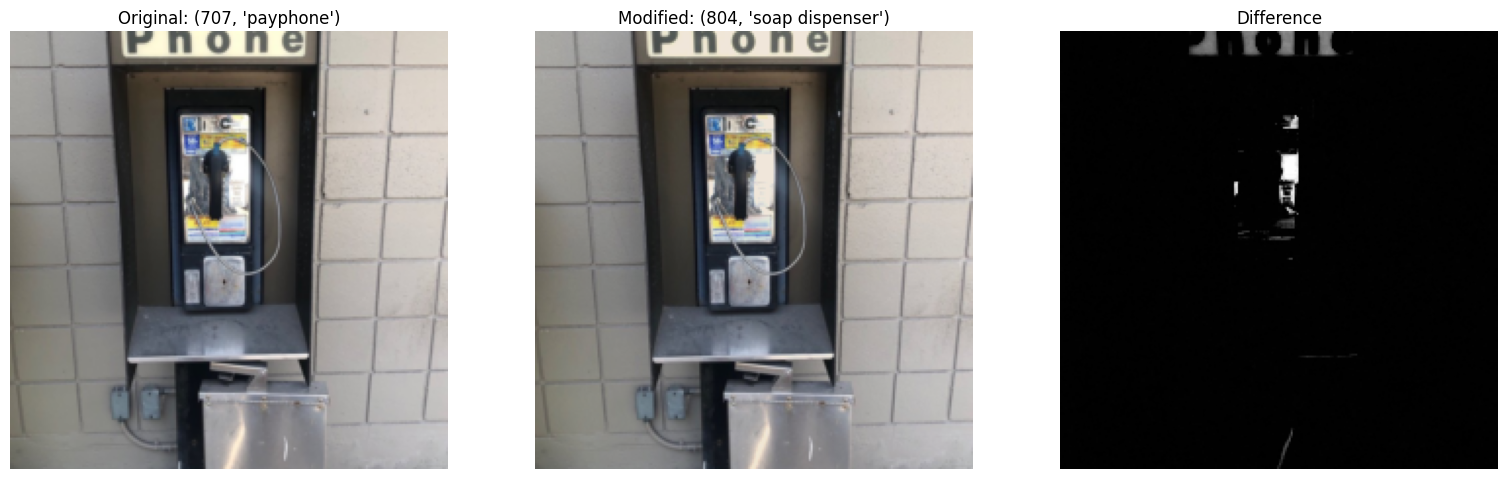

In [73]:
for i in range(5):

  img_path = f"{input_dir}/img_{i+1}.jpg"
  tensor = read_img(img_path, transform)

  print(f"-----------------------{img_path}-----------------------")

  new_tensor, orig_prediction, new_prediction = attack(
        tensor, net, eps=1e-3, n_iter=1000
        )

  _, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))
  arr = to_array(tensor)
  new_arr = to_array(new_tensor)
  diff_arr = np.abs(arr - new_arr).mean(axis=-1)
  diff_arr = diff_arr / diff_arr.max()

  ax_orig.imshow(arr)
  ax_new.imshow(new_arr)
  ax_diff.imshow(diff_arr, cmap="gray")

  ax_orig.axis("off")
  ax_new.axis("off")
  ax_diff.axis("off")

  ax_orig.set_title(f"Original: {orig_prediction, get_label_from_index(orig_prediction)}")
  ax_new.set_title(f"Modified: {new_prediction, get_label_from_index(new_prediction)}")
  ax_diff.set_title("Difference")

  plt.savefig(f"{output_dir}/img_{i+1}.jpg")
